<a href="https://colab.research.google.com/github/Sruthi-22/AINE.AI/blob/main/Project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 7: Statistical Analysis and Hypothesis Testing

## Packages and setup

In [47]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Reading data and initial processing

In [48]:
#Read data using pandas
user_df=pd.read_csv("cookie_cats.csv")

#Check data types of each column using "dtypes" function
print("Data types for the data set:")
user_df.dtypes

#Check dimension of data i.e. # of rows and #column using pandas "shape" funtion
print("Shape of the data i.e. no. of rows and columns")
user_df.shape

#display first 5 rows of the data using "head" function
print("First 5 rows of the raw data:")
user_df.head(5)

Data types for the data set:


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Shape of the data i.e. no. of rows and columns


(90189, 5)

First 5 rows of the raw data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Exercise

## Q1. Detect and resolve problems in the data (Missing value, Outliers, etc.)

### Q1.1 Identify missing value

In [49]:
#Check for any missing values in the data using isnull() function

user_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### Q1.2 Identify outliers

Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

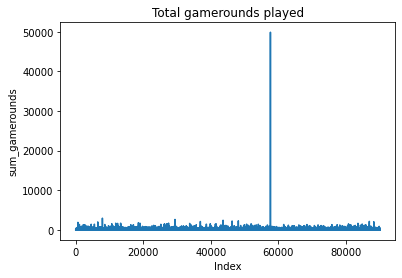

In [50]:
#Check for outlier values in sum_gamerounds column
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

In [51]:
#Based on the plot, filter out the outlier from sum_gamerounds played; Use max() fucntion to find the index of the outlier
user_df['sum_gamerounds'].idxmax()
user_df = user_df.drop(user_df.index[57702])


57702

Text(0.5, 1.0, 'Total gamerounds playeds without outlier')

Text(0.5, 0, 'Índex')

Text(0, 0.5, 'sum_gamerounds')

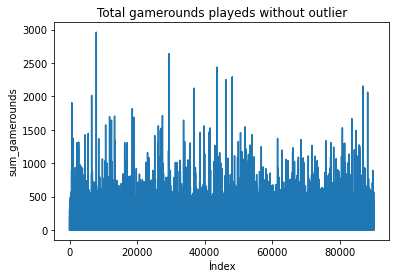

In [52]:
#Plot the graph for sum_gamerounds player after removing the outlier
plt.title('Total gamerounds playeds without outlier')
plt.xlabel('Índex')
plt.ylabel('sum_gamerounds')
plt.plot(user_df.sum_gamerounds)

## Q2. Plot summary statistics and identify trends to answer basis business questions

### Q2.1 What is the overall 7-day retention rate of the game?

In [53]:
#Insert calculation for 7-day retention rate

retention_rate_7= (user_df['retention_7'].values.sum())/(user_df['userid'].count())*100
print("Overal 7 days retention rate of the game for both versions is: " ,retention_rate_7,"%")


Overal 7 days retention rate of the game for both versions is:  18.60557945624695 %


### Q2.2 How many players never played the game after installing? 

In [54]:
# Find number of customers with sum_gamerounds is equal to zero
zero_sum_gamerounds = user_df.loc[user_df['sum_gamerounds']==0]
print('Number of games with zero rounds played: ', zero_sum_gamerounds['userid'].count())

Number of games with zero rounds played:  3994


### Q2.3 Does the number of users decrease as the level progresses highlighting the difficulty of the game?

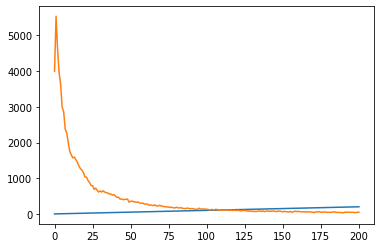

In [55]:
#Group by sum_gamerounds and count the number of users for the first 200 gamerounds
#Use plot() function on the summarized stats to visualize the chart
first_200 = user_df.groupby('sum_gamerounds').userid.count().reset_index().head(201)
plt.plot(first_200)


## Q3. Generate crosstab for two groups of players to understand if there is a difference in 7 days retention rate & total number of game rounds played

### Q3.1 Seven days retention rate summary for different game versions

In [56]:
#Create cross tab for game version and retention_7 flag counting number of users for each possible categories

pd.crosstab(user_df.version, user_df.retention_7).apply(lambda r: r/r.sum(), axis=1)

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


<mark>__Analsysis Results:__
    
Type your interpretation here from the crosstab generated above   

__Answer:__ The seven-day retention of gate_30 is higher than that of gate_40

### Q3.2 Gamerounds summary for different game versions

In [57]:
#use pandas group by to calculate average game rounds played summarized by different versions
user_df['retention'] = np.where((user_df.retention_1 == True) & (user_df.retention_7 == True), 1, 0)
user_df.groupby(['version', 'retention'])['sum_gamerounds'].agg(['count', 'median', 'mean', 'std', 'max'])

count  median        mean         std   max
version retention                                             
gate_30 0          38023      12   28.070273   48.017452  1072
        1           6676     127  183.886309  189.626390  2961
gate_40 0          38983      12   28.103353   48.927850  2640
        1           6506     133  190.282355  194.220077  2294

<mark>__Analsysis Results:__
    
Do total number of gamerounds played in total by each player differ based on  different versions of the game? 

__Answer:__ The difference between both versions of the game is very minute; not a significant difference

## Q4. Perform two-sample test for groups A and B to test statistical significance amongst the groups in the sum of game rounds played i.e., if groups A and B are statistically different

### Initial data processing

In [58]:
#Define A/B groups for hypothesis testing
user_df["version"] = np.where(user_df.version == "gate_30", "A", "B")
group_A=pd.DataFrame(user_df[user_df.version=="A"]['sum_gamerounds'])
group_B=pd.DataFrame(user_df[user_df.version=="B"]['sum_gamerounds'])

groupA=user_df[user_df.version=="A"]['sum_gamerounds']
groupB=user_df[user_df.version=="B"]['sum_gamerounds']

### Q4.1 Shapiro test of Normality

In [59]:
#---------------------- Shapiro Test ----------------------
# NULL Hypothesis H0: Distribution is normal
# ALTERNATE Hypothesis H1: Distribution is not normal    

#test for group_A
shapiro(group_A)

#test for group_B
shapiro(group_B)

(0.48864424228668213, 0.0)

(0.48256540298461914, 0.0)

<mark>__Analsysis Results:__
    
__Type your answer here:__ Analyze and interpret the results of shapiro test of normality i.e. are the two groups normally distributed?

__Answer__: As p < 0.05, distribution is _not_ normal

### Q4.2 Test of homegienity of variance

In [60]:
#---------------------- Leven's Test ----------------------
# NULL Hypothesis H0: Two groups have equal variances
# ALTERNATE Hypothesis H1: Two groups do not have equal variances

#perform levene's test and accept or reject the null hypothesis based on the results
stats.levene(groupA,groupB)


LeveneResult(statistic=0.07510153837481241, pvalue=0.7840494387892463)

<mark>__Analsysis Results:__
    
__Type your answer here:__ Write your final recommendation from the results of Levene's test

__Answer__: As p < 0.05, distribution is _not_ normal

### Q4.3 Test of significance: Two sample test

In [62]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: Two samples are different

#Apply relevant two sample test to accept or reject the NULL hypothesis

from scipy.stats import mannwhitneyu
mannwhitneyu(groupA,groupB)


MannwhitneyuResult(statistic=1009027049.5, pvalue=0.02544577639572688)

<mark>__Analsysis Results:__
    
__Type your answer here:__ Write your final recommendation from the results of two sample hyothesis testing

__Answer:__ As p < 0.05, the null hypothesis is rejected; both groups are different


## Q5. Based on significance testing results, if groups A and B are statistically different, which level has more advantage in terms of player retention and number of game rounds played

In [61]:
#Analyze the 1 day and 7 days retention rate for two different groups using group by function

user_df.groupby('version').retention_1.mean()

user_df.groupby('version').retention_7.mean()


version
A    0.448198
B    0.442283
Name: retention_1, dtype: float64

version
A    0.190183
B    0.182000
Name: retention_7, dtype: float64

<mark>__Analsysis Results:__
    
__Type your answer here:__ Write your final recommendation to the company regarding which level works best as the first gate  - Level 30 or Level 40

__Answer:__ Day 1 and 7 is higher in level_30, so I would suggest level 30


## Q6. [Bonus Question]  Using bootstrap resampling, plot the retention rate distribution for both the groups inorder to visualize effect of different version of the game on retention.

In [ ]:
#Hint: Plot density function